In [1]:
import numpy as np
import matplotlib.pyplot as plt
from napari_flim_phasor_plotter import _synthetic as syn
from scipy.stats import norm
from scipy.signal import convolve
from skimage.restoration import richardson_lucy

## GT Single Lifetime

In [2]:
def calculate_exp(x, A, tau):
    import numpy as np
    if np.isscalar(tau):
        tau = np.array([tau])
        A = np.array([A])
    return np.sum(A[:, None] * np.exp(-1/tau[:, None]*x), axis = 0)

In [3]:
laser_frequency = 40 # MHz
number_of_time_points = 300
small_time_array = syn.create_time_array(laser_frequency,number_of_time_points)

tau_1 = 0.7
tau_2 = 2
a1 = 1
two_amplitudes = np.array([a1, 1-a1])
tau_array = np.array([tau_1,tau_2])

In [4]:
normalized_counts = calculate_exp(small_time_array, two_amplitudes, tau_array)

## GT IRF

In [5]:
sigma = 0.2 #ns
offset = 3*sigma

syn_irf = norm.pdf(small_time_array, loc = offset, scale = sigma)

syn_irf = syn_irf/np.max(syn_irf)

syn_irf = syn_irf[:16]

In [6]:
syn_irf = norm.pdf(small_time_array, loc = offset, scale = sigma)


## Convolution

In [7]:
def create_synthetic_decay(number_of_output_time_points, amplitudes, life_times, laser_frequency = 40, offset = 0.3, irf_fwhm = 0.1, round_to_int = False):
    import numpy as np
    from scipy.stats import norm
    from scipy.signal import convolve
    from napari_flim_phasor_plotter import _synthetic as syn

    ratio = int(np.rint(10000/number_of_output_time_points))
    number_of_time_points = ratio * number_of_output_time_points
    smooth_time = syn.create_time_array(laser_frequency,number_of_time_points)
    smooth_decay = calculate_exp(smooth_time, amplitudes, life_times)
    smooth_irf = norm.pdf(smooth_time, loc = offset, scale = irf_fwhm)
    smooth_irf = smooth_irf[smooth_irf>0]
    smooth_irf /= np.max(smooth_irf)
    smooth_convolved = convolve(smooth_decay, smooth_irf, mode = "full", method = "direct")
    descaled_convolution = smooth_convolved[::ratio][:number_of_output_time_points]
    descaled_convolution /= np.max(descaled_convolution)
    if round_to_int:
        return(np.rint(descaled_convolution).astype("int"))
    else:
        return(descaled_convolution)

In [8]:
lifetime_counts = create_synthetic_decay(300, two_amplitudes, tau_array, laser_frequency, offset, sigma)
d_lifetime_signal = np.diff(lifetime_counts)
d_lifetime_signal_rise = d_lifetime_signal[:np.argmax(d_lifetime_signal)+1]

In [9]:
syn_irf_rebuilt = np.concatenate((d_lifetime_signal_rise, d_lifetime_signal_rise[-2::-1]))
syn_irf_rebuilt /= np.amax(syn_irf_rebuilt)

## Deconvolve
Fix code below

In [10]:
lifetime_signal_rebuilt = convolve(normalized_counts, syn_irf_rebuilt, mode='full')[:len(normalized_counts)]

In [11]:
d_exp_decay = richardson_lucy(image = lifetime_signal_rebuilt/np.max(lifetime_signal_rebuilt), 
psf = syn_irf_rebuilt, num_iter = 50)

In [12]:
sum(d_exp_decay[d_exp_decay==1]) 

3.0

In [13]:
d_exp_maximums = (d_exp_decay == np.max(d_exp_decay)).nonzero()[0]

In [14]:
len(d_exp_decay[d_exp_maximums[-1]:])

291

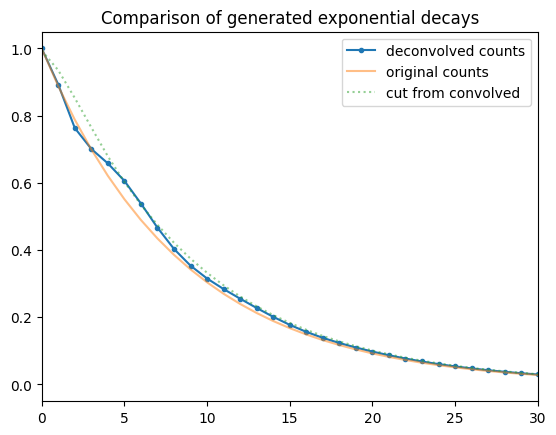

In [15]:
plt.plot(d_exp_decay[d_exp_maximums[-1]:], '.-', label = "deconvolved counts")
plt.plot(normalized_counts, alpha = 0.5, label = "original counts")
plt.plot((lifetime_signal_rebuilt/np.max(lifetime_signal_rebuilt))[np.argmax(lifetime_signal_rebuilt)+1:], ls = ":",alpha = 0.5, label = "cut from convolved")
plt.legend()
plt.xlim(left = 0,right = 30)
plt.title("Comparison of generated exponential decays")
plt.show()

Works Well!!

In [16]:
from scipy.fft import (fft, ifft, fftshift)


In [17]:
filtered = ifft(fft(lifetime_counts) / fft(syn_irf,len(lifetime_counts)))

/Users/lana/mambaforge/envs/napari-phasor-plotter-dev/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


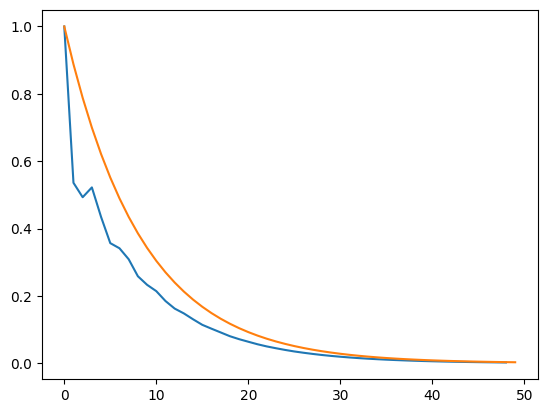

In [19]:
plt.plot((filtered/np.max(filtered))[1:50])
plt.plot(normalized_counts[:50])
plt.show()

### Testing deconvolution ideas from ChatGPT

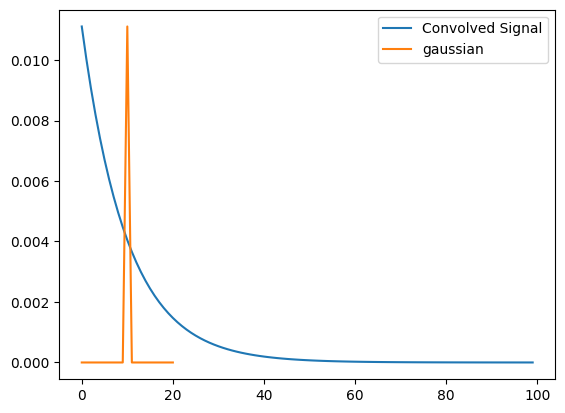

In [143]:
import numpy as np
from scipy.signal import convolve
from scipy.signal import fftconvolve
from scipy.signal import deconvolve

# Create the original exponential decay signal
original_length = 100
original_decay = np.exp(-np.linspace(0, 10, original_length))

# Create the Gaussian PSF
gaussian_length = 20
gaussian_psf = np.exp(-((np.arange(-gaussian_length//2, gaussian_length//2 + 1)-0.3) ** 2) / (2 * 0.1 ** 2))

# Convolve the original decay with the Gaussian PSF
convolved_signal = convolve(original_decay, gaussian_psf, mode='same')

# Perform deconvolution using Richardson-Lucy
iterations = 100
restoration = convolved_signal.copy()
for _ in range(iterations):
    error = original_decay / fftconvolve(restoration, gaussian_psf, mode='same')
    restoration *= fftconvolve(error, gaussian_psf[::-1], mode='same')

# Plot the original decay, convolved signal, and the restored signal
import matplotlib.pyplot as plt
#plt.plot(original_decay, label='Original Decay')
plt.plot(convolved_signal, label='Convolved Signal')
#plt.plot(restoration, label='Restored Signal')
plt.plot(gaussian_psf, label='gaussian')
plt.legend()
plt.show()

In [144]:
from napari_flim_phasor_plotter import phasor
from scipy.fft import (fft, ifft, fftshift,ifftshift)
from scipy.signal import fftconvolve
from skimage.restoration import denoise_tv_chambolle

In [151]:
observed_G, observed_S = fft(lifetime_counts).real, fft(lifetime_counts).imag

In [152]:
psf_G, psf_S = fft(syn_irf[:16]).real, fft(syn_irf[:16]).imag

In [147]:
# Initial estimates for G and S phasor components
G = observed_G.copy()
S = observed_S.copy()

iterations = 50
alpha = 0.1  # Regularization strength

In [149]:
for _ in range(iterations):
    print(_)
    error_G = observed_G / fftconvolve(G, psf_G, mode='same')
    error_S = observed_S / fftconvolve(S, psf_S, mode='same')

    # Richardson-Lucy update
    G *= fftconvolve(error_G, psf_G[::-1], mode='same')
    S *= fftconvolve(error_S, psf_S[::-1], mode='same')

    # Apply total variation regularization
    G = denoise_tv_chambolle(G, weight=alpha)
    S = denoise_tv_chambolle(S, weight=alpha)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


/var/folders/98/z1bbxw4s2g722hyr6_n99t5w0000gn/T/ipykernel_27233/1875834985.py:4: RuntimeWarning: divide by zero encountered in divide
  error_S = observed_S / fftconvolve(S, psf_S, mode='same')
/Users/lana/mambaforge/envs/napari-phasor-plotter-dev/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


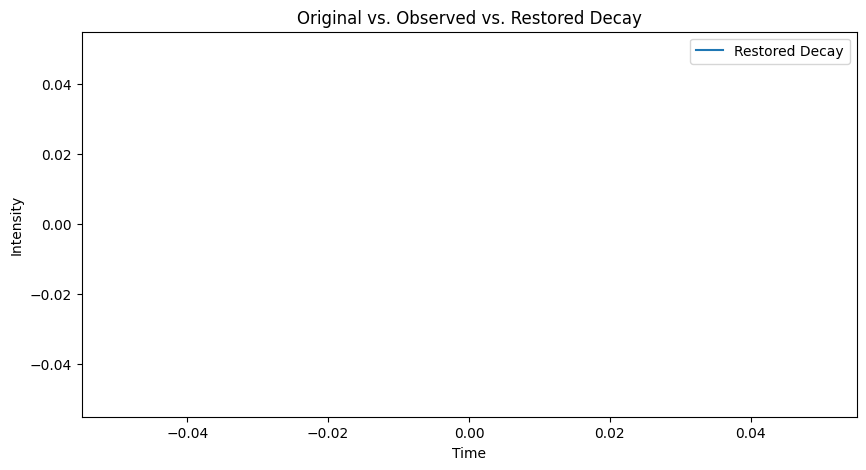

In [153]:
restored_decay = G * convolve(G, lifetime_counts, mode='same') + S * convolve(S, lifetime_counts, mode='same')

# Plot the original, observed, and restored fluorescence decay curves
plt.figure(figsize=(10, 5))
plt.plot(restored_decay, label='Restored Decay')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title('Original vs. Observed vs. Restored Decay')
plt.show()